## Data splits ##
Split the data into training, validation and testing data

In [13]:
import os
import sys
import glob
import random
import logging
import json
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import cv2

import albumentations as alb

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2
import computervision
from computervision.dentex import Dentex
from computervision.imageproc import ImageData
from computervision.transformations import AugmentationTransform, DETRansform

# Print version info
print(f'Package version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Package version: v0.0.1
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [14]:
data_dir = os.path.join(os.environ.get('HOME'), 'data')
print(f'data_dir: {data_dir}')

# Directory to store the data
dataset_dir = os.path.join(data_dir, 'dentex')

# After extraction from the .tar.gz archive, the images should be on the local fs (see the first notebook)
xrays_dir = os.path.join(dataset_dir, 'cropped')

data_dir: /app/data


In [15]:
# Function to plot an image with the bounding boxes
def plot_boxes(image, box_list, ax, label_list=None, color=None, cmap='grey'):
    offset_xy = (10, 100)
    # Take a ratio that looks good
    offset = (image.shape[1]*offset_xy[0]/2500,
              image.shape[0]*offset_xy[1]/1250)
    if color is None:
        # If no color is provided, color each box in a different color
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(box_list))))
    else:
        color_list = [color]*len(box_list)
    ax.set(xticks=[], yticks=[])
    ax.imshow(image, cmap=cmap)
    # Loop over the bounding boxes
    for b, box in enumerate(box_list):
        rect = Rectangle(xy=(box[0], box[1]),
                         width=box[2],
                         height=box[3],
                         linewidth=1.5,
                         edgecolor=color_list[b],
                         facecolor='none',
                         alpha=0.7)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=box[0]+offset[0], y=box[1]+offset[1], s=label_list[b], color=color_list[b], fontsize=8)
    return ax

## Load the annotations ##

In [16]:
parquet_file_name = 'train_quadrant_enumeration_cropped.parquet'
parquet_file = os.path.join(xrays_dir, parquet_file_name)
try:
    df = pd.read_parquet(parquet_file)
except Exception as e:
    print(f'ERROR: Could not load file: \n {e}')
    print('Make sure to run the first notebook which downloads the data.')
display(df.head())

# Create a file name for the data split
split_file_name = f'{os.path.splitext(parquet_file_name)[0]}_dset.parquet'
split_file = os.path.join(xrays_dir, split_file_name)
print(split_file)

# Let's make sure that we have the expected number of images available
# If the image numbers don't match, please run the first three notebooks.
expected_images = len(df['file_name'].unique())
file_list = glob.glob(os.path.join(xrays_dir, '*.png'))
print(f'Found {len(file_list)} images in {xrays_dir}')
print(f'Expected number of images is {expected_images}.')

# We want to be sure that the number of images is correct before we continue
assert expected_images == len(file_list), \
    f'WARNING: expected images ({expected_images}) != images on file system ({len(file_list)})'

,bbox,segmentation,height,width,file_name,file_base_name,quadrants,quadrant,pos,fdi,ada
0,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",494,1473,train_0_12.png,train_0,12,1,1,11,8
1,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",494,1473,train_0_12.png,train_0,12,1,2,12,7
2,"[531, 69, 85, 368]","[[587, 437, 616, 357, 607, 72, 534, 69, 531, 4...",494,1473,train_0_12.png,train_0,12,1,3,13,6
3,"[457, 31, 115, 403]","[[522, 434, 572, 378, 543, 31, 463, 40, 457, 3...",494,1473,train_0_12.png,train_0,12,1,4,14,5
4,"[369, 10, 100, 406]","[[437, 416, 469, 378, 466, 10, 381, 31, 378, 2...",494,1473,train_0_12.png,train_0,12,1,5,15,4


/app/data/dentex/cropped/train_quadrant_enumeration_cropped_dset.parquet
Found 2534 images in /app/data/dentex/cropped
Expected number of images is 2534.


In [17]:
# Number of panoramic x-rays for testing and validation 
n_test = 20
n_val = 16

# Start with a sorted list of panoramic x-rays
image_list = sorted(list(df['file_base_name'].unique()))
print(len(image_list))
# Shuffle the list
seed = 123
random.seed(seed)
random.shuffle(image_list)
print(image_list[:5])

# Now we can pick the images for validation and testing
val_image_list = image_list[:n_val]
test_image_list = image_list[n_val+1:n_val+n_test+1]
print(len(val_image_list))
print(len(test_image_list))

# Assign the data sets to the images
df = df.assign(dset='train')
df.loc[df['file_base_name'].isin(val_image_list), 'dset'] = 'val'
df.loc[df['file_base_name'].isin(test_image_list), 'dset'] = 'test'

# Count images and annotations for each data set
for dset in ['train', 'val', 'test']:
    n_base_images = len(df.loc[df['dset'] == dset, 'file_base_name'].unique())
    n_images = len(df.loc[df['dset'] == dset, 'file_name'].unique())
    n_annotations = df.loc[df['dset'] == dset, 'file_name'].shape[0]
    print()
    print(f'{dset.upper()}')
    print(f'Panoramic x-rays: {n_base_images}')
    print(f'Cropped images:   {n_images}')
    print(f'Annotations:      {n_annotations}')

634
['train_185', 'train_143', 'train_36', 'train_609', 'train_242']
16
20

TRAIN
Panoramic x-rays: 598
Cropped images:   2391
Annotations:      34166

VAL
Panoramic x-rays: 16
Cropped images:   63
Annotations:      886

TEST
Panoramic x-rays: 20
Cropped images:   80
Annotations:      1138


In [6]:
# Save the data frame
dset_file_name = f'{os.path.splitext(parquet_file_name)[0].\
    rsplit('_', maxsplit=1)[0]}_dset.parquet'
dset_file = os.path.join(xrays_dir, dset_file_name)
if not os.path.exists(dset_file):
    print(f'Saving data: {dset_file}')
    df.to_parquet(dset_file)
else:
    logger.warning(f'File {dset_file} exists. Skipping.')
display(df.sample(5))

File /app/data/dentex/cropped/train_quadrant_enumeration_dset.parquet exists. Skipping.


,bbox,segmentation,height,width,file_name,file_base_name,quadrants,quadrant,pos,fdi,ada,dset
30388,"[553, 62, 58, 218]","[[555, 70, 581, 62, 602, 67, 610, 85, 611, 126...",307,1172,train_579_34.png,train_579,34,4,1,41,25,train
27210,"[165, 10, 98, 380]","[[175, 304, 165, 330, 165, 348, 176, 372, 202,...",776,736,train_529_23.png,train_529,23,2,3,23,11,train
23647,"[701, 307, 175, 253]","[[876, 499, 826, 307, 754, 332, 701, 363, 712,...",759,886,train_472_23.png,train_472,23,3,8,38,17,train
26965,"[246, 149, 114, 282]","[[251, 149, 346, 150, 360, 390, 337, 431, 304,...",813,816,train_525_23.png,train_525,23,2,4,24,12,train
30960,"[638, 47, 57, 277]","[[658, 47, 647, 67, 638, 102, 638, 147, 647, 2...",429,1660,train_588_34.png,train_588,34,4,3,43,27,test


In [18]:
# Making sure that the data sets are distinct
train_images = set(sorted(list(df.loc[df['dset'] == 'train', 'file_name'].unique())))
val_images = set(sorted(list(df.loc[df['dset'] == 'val', 'file_name'].unique())))
test_images = set(sorted(list(df.loc[df['dset'] == 'test', 'file_name'].unique())))

print(f'Training images:   {len(train_images)}')
print(f'Validation images: {len(val_images)}')
print(f'Test images:       {len(test_images)}')

print(train_images.intersection(val_images))
print(train_images.intersection(test_images))
print(val_images.intersection(test_images))

Training images:   2391
Validation images: 63
Test images:       80
set()
set()
set()


### Create validation and test splits from random crops ###
We need to avoid random crops during testing/validation

In [19]:
# Load the data frame
print(dset_file)
df = pd.read_parquet(dset_file)
display(df.head())

/app/data/dentex/cropped/train_quadrant_enumeration_dset.parquet


,bbox,segmentation,height,width,file_name,file_base_name,quadrants,quadrant,pos,fdi,ada,dset
0,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",494,1473,train_0_12.png,train_0,12,1,1,11,8,train
1,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",494,1473,train_0_12.png,train_0,12,1,2,12,7,train
2,"[531, 69, 85, 368]","[[587, 437, 616, 357, 607, 72, 534, 69, 531, 4...",494,1473,train_0_12.png,train_0,12,1,3,13,6,train
3,"[457, 31, 115, 403]","[[522, 434, 572, 378, 543, 31, 463, 40, 457, 3...",494,1473,train_0_12.png,train_0,12,1,4,14,5,train
4,"[369, 10, 100, 406]","[[437, 416, 469, 378, 466, 10, 381, 31, 378, 2...",494,1473,train_0_12.png,train_0,12,1,5,15,4,train


In [20]:
# Output directory to save the test images
test_dir = os.path.join(xrays_dir, 'test')
Path(test_dir).mkdir(parents=True, exist_ok=True)

# Set the transformation (use the same random crop as we will use for traning)
im_size = 640
transformation_name = 'test_set'
transforms = AugmentationTransform(image_width=im_size, image_height=im_size).\
    get_transforms(transformation_name)

# Set the number of transformations per image
n_transforms = 10

# Save the data frame
test_file_name = f'{os.path.splitext(parquet_file_name)[0].\
    rsplit('_', maxsplit=1)[0]}_{transformation_name}.parquet'
test_file = os.path.join(test_dir, test_file_name)

In [26]:
# Only run this once. Because everytime we do this, the data is different
# Delete the data test_dir if you need to run this again.
if not os.path.exists(test_file):
    transformed_df_list = []
    # LOOP OVER DATA SET
    for dset in ['val', 'test']:
        
        df_dset = df.loc[df['dset'] == dset].reset_index(drop=True)
        file_name_list = sorted(list(df_dset['file_name'].unique()))
        
        # LOOP OVER THE IMAGES IN THE DATA SET
        for idx, file_name in enumerate(file_name_list):
    
            if (idx + 1) % 10 == 0:
                print(f'Loading image {idx + 1} / {len(file_name_list)} of data set {dset.upper()}')
            
            file = os.path.join(xrays_dir, file_name)
            df_file = df_dset.loc[df_dset['file_name'] == file_name]
            file_base_name = df_file['file_base_name'].tolist()[0]
            quadrants_base = df_file['quadrants'].tolist()[0]
    
            # Load the image and convert to RGB
            im = ImageData().load_image(file)
            im = ImageData().np2color(im)
            
            # Get the bounding boxes and positions
            boxes = df_file['bbox'].tolist()
            quadrants = df_file['quadrant'].tolist()
            positions = df_file['ada'].tolist()
            label_list = [f'Q{q}P{p}' for q, p in zip(quadrants, positions)]
            
            # Plot the original image
            # fig, ax = plt.subplots(figsize=(5, 5))
            # ax = plot_boxes(image=im, box_list=boxes, label_list=label_list, ax=ax)
            # ax.set(title=f'Original image {im.shape[:2]}')
            # plt.show()
            
            # LOOP OVER THE TRANSFORMATIONS
            for t in range(n_transforms):    
            
                # Generate the transform
                detr = DETRansform(transforms=transforms)
                output = detr.\
                    transform(image=im, bboxes=boxes, label_fields=[quadrants, positions])
                
                # Retrieve the image and annotations of the transformed image
                transformed_im = output['image']
                transformed_box_list = list(output['bboxes'])
                transformed_quadrant_list = list(np.array(output['quadrants']).astype(int))
                transformed_position_list = list(np.array(output['positions']).astype(int))
                transformed_label_list = [f'Q{q}P{p}' for q, p in zip(transformed_quadrant_list, 
                                                                      transformed_position_list)]
            
                # Save the image as a greyscale image
                transformed_file_name = f'{dset}_{os.path.splitext(file_name)[0]}_{str(t).zfill(2)}.png'
                transformed_image_file = os.path.join(test_dir, transformed_file_name)
                im_pil = Image.fromarray(transformed_im).convert('L')
                im_pil.save(transformed_image_file)
            
                # New data frame for the cropped image
                transformed_df = pd.DataFrame({'bbox': transformed_box_list,
                                               'quadrant': transformed_quadrant_list,
                                               'ada': transformed_position_list})
            
                transformed_df = transformed_df.assign(file_name=transformed_file_name,
                                                       file_base_name=file_base_name,
                                                       quadrants=quadrants_base,
                                                       height=transformed_im.shape[1],
                                                       width=transformed_im.shape[0],
                                                       transformation=t,
                                                       transformation_name=transformation_name,
                                                       dset=dset)
                
                transformed_df_list.append(transformed_df)
                
                # Plot the last image with bounding boxes
                # Making sure it is all correct
                # print(f'Transform {t + 1} / {n_transforms}')
                # fig, ax = plt.subplots(figsize=(5, 5))
                # ax = plot_boxes(image=transformed_im, box_list=transformed_box_list, label_list=transformed_label_list, ax=ax)
                # ax.set(title='Transformed')
                # plt.show()

    # Assemble the final data frame
    test_df = pd.concat(transformed_df_list, axis=0, ignore_index=True)
    print(f'Saving data: {test_file}')
    test_df.to_parquet(test_file)
else:
    logger.warning(f'File {test_file} exists. Skipping.')

Loading image 10 / 63 of data set VAL
Loading image 20 / 63 of data set VAL
Loading image 30 / 63 of data set VAL
Loading image 40 / 63 of data set VAL
Loading image 50 / 63 of data set VAL
Loading image 60 / 63 of data set VAL
Loading image 10 / 80 of data set TEST
Loading image 20 / 80 of data set TEST
Loading image 30 / 80 of data set TEST
Loading image 40 / 80 of data set TEST
Loading image 50 / 80 of data set TEST
Loading image 60 / 80 of data set TEST
Loading image 70 / 80 of data set TEST
Loading image 80 / 80 of data set TEST
Saving data: /app/data/dentex/cropped/test/train_quadrant_enumeration_test_set.parquet


In [27]:
transformed_df

,bbox,quadrant,ada,file_name,file_base_name,quadrants,height,width,transformation,transformation_name,dset
0,"[286, 0, 94, 47]",3,24,test_train_87_34_09.png,train_87,34,828,47,9,test_set,test
1,"[345, 0, 70, 47]",3,23,test_train_87_34_09.png,train_87,34,828,47,9,test_set,test
2,"[409, 0, 80, 47]",3,22,test_train_87_34_09.png,train_87,34,828,47,9,test_set,test
3,"[487, 0, 82, 47]",3,21,test_train_87_34_09.png,train_87,34,828,47,9,test_set,test
4,"[543, 0, 104, 47]",3,20,test_train_87_34_09.png,train_87,34,828,47,9,test_set,test
5,"[604, 0, 161, 47]",3,19,test_train_87_34_09.png,train_87,34,828,47,9,test_set,test
6,"[716, 0, 111, 47]",3,18,test_train_87_34_09.png,train_87,34,828,47,9,test_set,test
7,"[242, 0, 58, 47]",4,25,test_train_87_34_09.png,train_87,34,828,47,9,test_set,test
8,"[175, 0, 65, 47]",4,26,test_train_87_34_09.png,train_87,34,828,47,9,test_set,test
9,"[100, 0, 83, 47]",4,27,test_train_87_34_09.png,train_87,34,828,47,9,test_set,test


### Look at the validation/test data ###
Now, we have created deterministic test/validation data sets.

,bbox,quadrant,ada,file_name,file_base_name,quadrants,height,width,transformation,transformation_name,dset
0,"[439, 21, 93, 260]",1,8,val_train_143_12_00.png,train_143,12,921,282,0,test_set,val
1,"[379, 46, 71, 235]",1,7,val_train_143_12_00.png,train_143,12,921,282,0,test_set,val
2,"[294, 0, 99, 282]",1,6,val_train_143_12_00.png,train_143,12,921,282,0,test_set,val
3,"[234, 49, 101, 232]",1,5,val_train_143_12_00.png,train_143,12,921,282,0,test_set,val
4,"[175, 24, 104, 257]",1,4,val_train_143_12_00.png,train_143,12,921,282,0,test_set,val



DATA SET: VAL



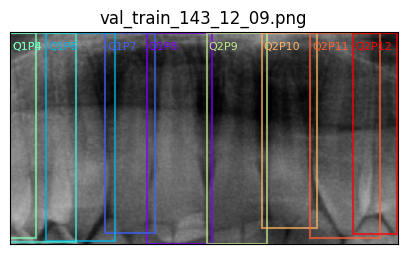

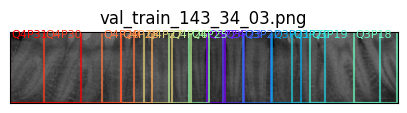

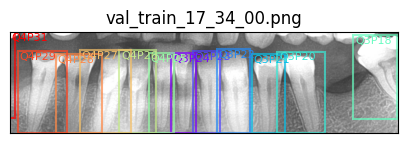

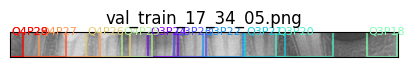

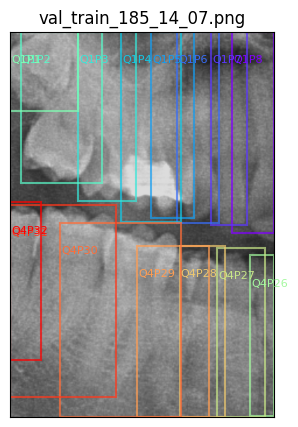

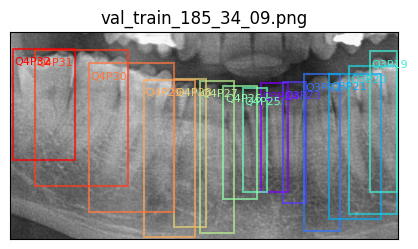

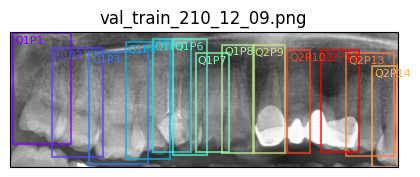

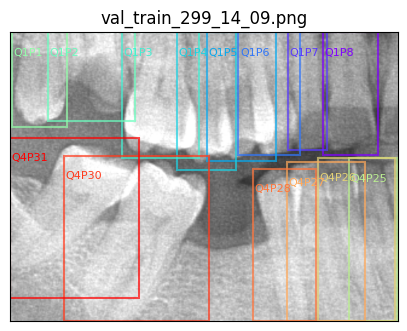

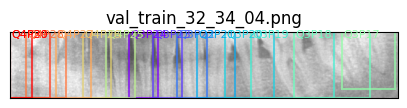

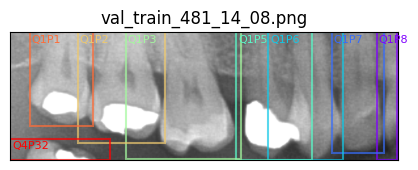


DATA SET: TEST



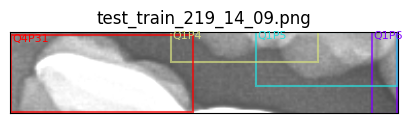

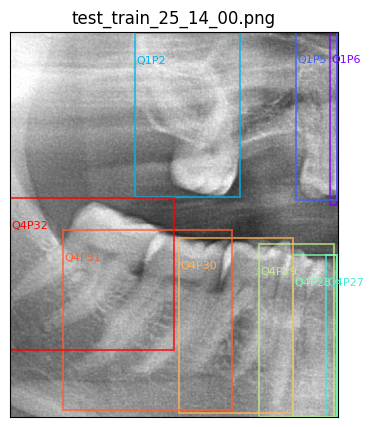

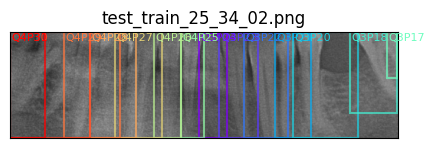

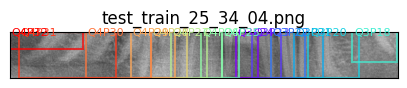

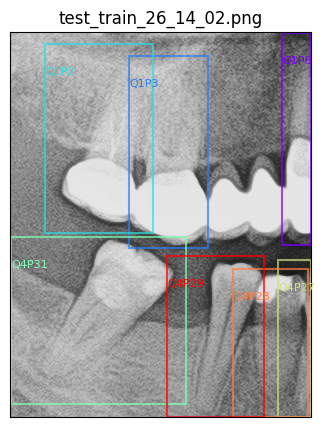

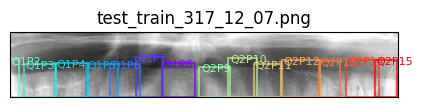

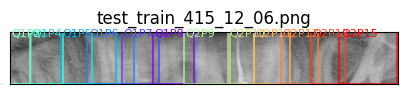

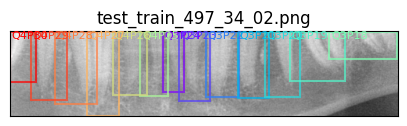

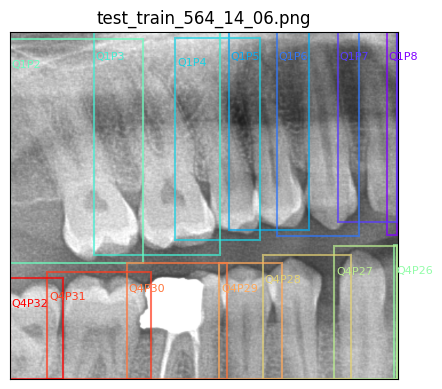

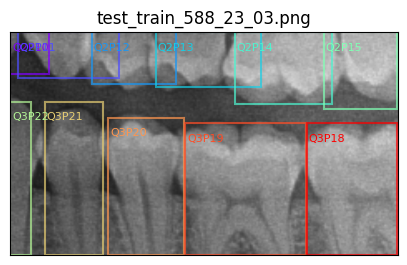

In [28]:
# Let's save the example images with the bounding boxes
test_data_output_dir = os.path.join(test_dir, 'examples')
Path(test_data_output_dir).mkdir(exist_ok=True, parents=True)

# Check the data
test_df = pd.read_parquet(test_file)
display(test_df.head())
seed = 123
rng = np.random.default_rng(seed)

# Decide, how many images per data set we want
n_samples_per_dset = 10

for dset in ['val', 'test']:
    print()
    print(f'DATA SET: {dset.upper()}')
    print()
    file_names = sorted(list(test_df.loc[test_df['dset'] == dset, 'file_name'].unique()))
    file_name_list = sorted(list(rng.choice(file_names, size=n_samples_per_dset, replace=False)))
    for f, file_name in enumerate(file_name_list):
        file = os.path.join(test_dir, file_name)
        test_df_file = test_df.loc[test_df['file_name'] == file_name]
        # Create a new file name 
        test_image_file_name = f'{os.path.splitext(file_name)[0]}_boxes.png'
        test_image_file = os.path.join(test_data_output_dir, test_image_file_name)
        # Load the image and convert to RGB
        im = ImageData().load_image(file)
        im = ImageData().np2color(im)  
        # Get the bounding boxes and positions
        boxes = test_df_file['bbox'].tolist()
        quadrants = test_df_file['quadrant'].tolist()
        positions = test_df_file['ada'].tolist()
        label_list = [f'Q{q}P{p}' for q, p in zip(quadrants, positions)]
        # Plot the image with the bounding boxes
        fig, ax = plt.subplots(figsize=(5, 5))
        ax = plot_boxes(image=im, box_list=boxes, label_list=label_list, ax=ax)
        ax.set(title=f'{file_name}')
        plt.savefig(test_image_file, bbox_inches='tight')
        plt.show()